<a href="https://colab.research.google.com/github/ldabas/QuantumResearch/blob/master/Running_Average_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#! pip install --upgrade Cython
#! pip install --upgrade git+https://github.com/statsmodels/statsmodels
#import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor

Mounted at /content/drive


In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Dataset.xlsx', sheet_name=['SS(Ave)', 'FE','AT(Ave)'])


In [ ]:
# In order to use this file, please upload Dataset.xlsx to your googledrive. Do not change the name
dfss = pd.read_excel('/content/drive/MyDrive/Dataset.xlsx', sheet_name='SS(Ave)')
dfss['Datetime'] = pd.to_datetime(dfss['Date'])
dfss = dfss.set_index('Datetime')
dfss = dfss.drop(['YYYY-MM','Date'], axis=1)

dffe = pd.read_excel('/content/drive/MyDrive/Dataset.xlsx', sheet_name='FE')
dffe['Datetime'] = pd.to_datetime(dffe['Date'])
dffe = dffe.set_index('Datetime')
dffe = dffe.drop(['YYYY-MM','Date'], axis=1)

dfat = pd.read_excel('/content/drive/MyDrive/Dataset.xlsx', sheet_name='AT(Ave)')
dfat['Datetime'] = pd.to_datetime(dfat['Date'])
dfat = dfat.set_index('Datetime')
dfat = dfat.drop(['YYYY-MM','Date'], axis=1)

In [ ]:
dfss_bod = dfss[['BOD', 'NH3-N', 'TN','PH']] #SSE dataset containing BOD, NH3, and TN values
dfat_bod=dfat[['MLSS','AT_Temp']]
dffe_bod = dffe[['BOD']] #FE dataset containing NH3 values
dffe_bod.columns = ['OUTPUT BOD']

dfss_bodMA = dfss_bod.rolling(5, min_periods=1).mean()
dfat_bodMA=dfat_bod.rolling(5, min_periods=1).mean()
#dffe_bodMA=dffe_bod.rolling(5, min_periods=1).mean()

dfss_bod.fillna(dfss_bodMA,inplace=True)
dfat_bod.fillna(dfat_bodMA,inplace=True)
#dffe_bod.fillna(dffe_bodMA,inplace=True)

bod_data = pd.concat([dfss_bod,dfat_bod,dffe_bod], axis=1)

#bod_data.drop(bod_data.loc[bod_data['OUTPUT BOD'] < 5.00000001 ].index, inplace=True)

bod_data = bod_data.dropna()
print(bod_data)



              BOD  NH3-N    TN   PH    MLSS  AT_Temp  OUTPUT BOD
Datetime                                                        
2013-01-03  120.0   31.0  45.0  8.1  2540.0   22.400         5.0
2013-01-10   38.0   25.0  48.0  8.3  2250.0   22.150         5.0
2013-01-17  160.0   24.0  42.0  7.5  1990.0   21.925         5.0
2013-01-24  150.0   28.0  41.0  7.4  2190.0   22.975         5.0
2013-01-31  130.0   26.0  41.0  7.2  2090.0   22.750         5.0
...           ...    ...   ...  ...     ...      ...         ...
2018-11-29  160.0   25.0  45.0  7.2  2890.0   24.425         5.0
2018-12-06  170.0   28.0  50.0  7.1  3450.0   25.100         5.0
2018-12-13  130.0   30.0  48.0  7.2  3060.0   21.800         5.0
2018-12-20  180.0   30.0  48.0  7.2  2830.0   25.525         5.0
2018-12-27  120.0   31.0  56.0  7.3  3430.0   23.150         5.0

[351 rows x 7 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
from sklearn.model_selection import train_test_split


features= bod_data[['BOD', 'NH3-N', 'TN','MLSS','PH','AT_Temp']]
labels= bod_data[['OUTPUT BOD']]


# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.20, random_state = 42)

rf = RandomForestRegressor(n_estimators = 10, random_state = 42)

rf.fit(train_features, train_labels)

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
print (predictions.shape)
predictions=predictions.reshape(71,1)

# Calculate the absolute errors
errors = np.abs(predictions - test_labels)

# Print out the mean absolute error (mae)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'mg/L.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

(71,)
Mean Absolute Error: OUTPUT BOD    0.44
dtype: float64 mg/L.
Accuracy: OUTPUT BOD    93.78
dtype: float64 %.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


In [ ]:
# Import tools needed for visualization
feature_list = list(features.columns)
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'BOD_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('BOD_tree.dot')
# Write graph to a png file
graph.write_png('BOD_tree.png')
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Variable: MLSS                 Importance: 0.24
Variable: AT_Temp              Importance: 0.22
Variable: PH                   Importance: 0.19
Variable: BOD                  Importance: 0.12
Variable: NH3-N                Importance: 0.12
Variable: TN                   Importance: 0.11


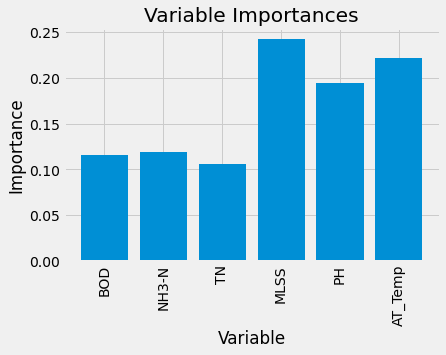

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.show()

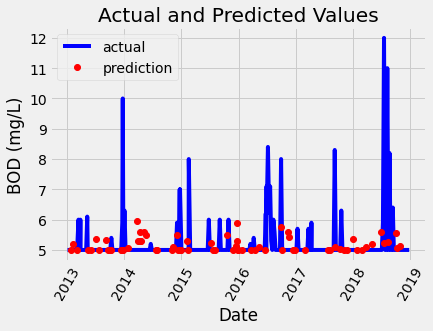

In [ ]:
# Use datetime for creating date objects for plotting
import datetime

# Dataframe with true values and dates
true_data = pd.DataFrame(labels)


# Dataframe with predictions and dates
predictions_data = pd.DataFrame(predictions)
#print(predictions_data)
#predictions_data = predictions_data.reset_index()

#predictions_data.columns = ['prediction', 'date']
# predictions_data.date = pd.to_datetime(predictions_data.date)

# Plot the actual values
plt.plot(true_data.index, true_data['OUTPUT BOD'], 'b-', label = 'actual')
# Plot the predicted values
plt.plot(test_features.index, predictions_data[0], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('BOD (mg/L)'); plt.title('Actual and Predicted Values');
plt.show()

In [ ]:
dfss_tn = dfss[['BOD', 'NH3-N', 'TN','PH']] #SSE dataset containing BOD, NH3, and TN values
dfat_tn=dfat[['MLSS','AT_Temp']]
dffe_tn = dffe[['TN']] #FE dataset containing NH3 values


dfss_tnMA = dfss_tn.rolling(5, min_periods=1).mean()
dfat_tnMA=dfat_tn.rolling(5, min_periods=1).mean()
dffe_tnMA=dffe_tn.rolling(5, min_periods=1).mean()

dfss_tn.fillna(dfss_tnMA,inplace=True)
dfat_tn.fillna(dfat_tnMA,inplace=True)
dffe_tn.fillna(dffe_tnMA,inplace=True)

dffe_tn.columns = ['OUTPUT TN']
tn_data = pd.concat([dfss_tn,dfat_tn,dffe_tn], axis=1)

tn_data = tn_data.dropna()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
from sklearn.model_selection import train_test_split


features= tn_data[['BOD', 'NH3-N', 'TN','MLSS','PH','AT_Temp']]
labels= tn_data[['OUTPUT TN']]


# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.20, random_state = 42)

rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

rf.fit(train_features, train_labels)

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
print (predictions.shape)
predictions=predictions.reshape(307,1)

# Calculate the absolute errors
errors = np.abs(predictions - test_labels)

# Print out the mean absolute error (mae)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'mg/L.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


(307,)
Mean Absolute Error: OUTPUT TN    0.96
dtype: float64 mg/L.
Accuracy: OUTPUT TN    86.43
dtype: float64 %.


In [ ]:
# Import tools needed for visualization
feature_list = list(features.columns)
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'TN_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('TN_tree.dot')
# Write graph to a png file
graph.write_png('TN_tree.png')
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Variable: MLSS                 Importance: 0.27
Variable: AT_Temp              Importance: 0.19
Variable: TN                   Importance: 0.17
Variable: BOD                  Importance: 0.13
Variable: PH                   Importance: 0.13
Variable: NH3-N                Importance: 0.11


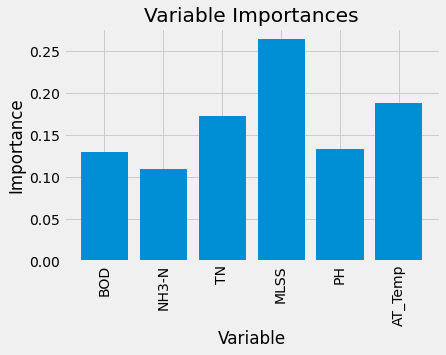

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.show()

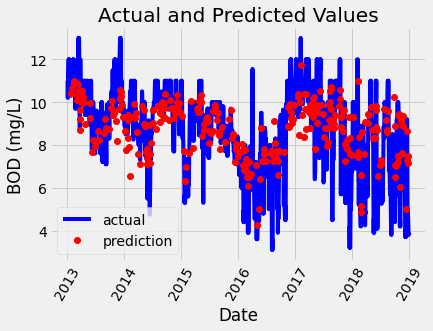

In [ ]:
# Use datetime for creating date objects for plotting
import datetime

# Dataframe with true values and dates
true_data = pd.DataFrame(labels)


# Dataframe with predictions and dates
predictions_data = pd.DataFrame(predictions)
#print(predictions_data)
#predictions_data = predictions_data.reset_index()

#predictions_data.columns = ['prediction', 'date']
# predictions_data.date = pd.to_datetime(predictions_data.date)

# Plot the actual values
plt.plot(true_data.index, true_data['OUTPUT TN'], 'b-', label = 'actual')
# Plot the predicted values
plt.plot(test_features.index, predictions_data[0], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('BOD (mg/L)'); plt.title('Actual and Predicted Values');
plt.show()

In [ ]:
dfss_nh3 = dfss[['BOD', 'NH3-N', 'TN','PH']] #SSE dataset containing BOD, NH3, and TN values
dfat_nh3=dfat[['MLSS','AT_Temp']]
dffe_nh3 = dffe[['NH3-N']] #FE dataset containing NH3 values

dfss_nh3MA = dfss_nh3.rolling(5, min_periods=1).mean()
dfat_nh3MA=dfat_nh3.rolling(5, min_periods=1).mean()
dffe_nh3MA=dffe_nh3.rolling(5, min_periods=1).mean()

dfss_nh3.fillna(dfss_nh3MA,inplace=True)
dfat_nh3.fillna(dfat_nh3MA,inplace=True)
dffe_nh3.fillna(dffe_nh3MA,inplace=True)

dffe_nh3.columns = ['OUTPUT NH3']

nh3_data.drop(nh3_data.loc[nh3_data['OUTPUT NH3']==0.5].index, inplace=True)
nh3_data = nh3_data[nh3_data['OUTPUT NH3'] > 0.50]
nh3_data = nh3_data[nh3_data['OUTPUT NH3'] > 0.5]
nh3_data = pd.concat([dfss_nh3,dfat_nh3,dffe_nh3], axis=1)

nh3_data.drop(nh3_data.loc[nh3_data['OUTPUT NH3'] <0.5000001 ].index, inplace=True)
nh3_data = nh3_data.dropna()
print (nh3_data)

nh3_data.plot(y='OUTPUT NH3', use_index=True)

# plt.plot(nh3_data[0],nh3_data['OUTPUT NH3'])

#from pandas import ExcelWriter

#writer = ExcelWriter('PythonExport.xlsx')
#nh3_data.to_excel(writer,'Sheet5')
#writer.save()


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


NameError: ignored

In [ ]:
from sklearn.model_selection import train_test_split


features= nh3_data[['BOD', 'NH3-N', 'TN','MLSS','PH','AT_Temp']]
labels= nh3_data[['OUTPUT NH3']]

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.20, random_state = 42)

rf = RandomForestRegressor(n_estimators = 10, random_state = 42)

rf.fit(train_features, train_labels)

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
print (predictions.shape)
predictions=predictions.reshape(69,1)

# Calculate the absolute errors
errors = np.abs(predictions - test_labels)

# Print out the mean absolute error (mae)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'mg/L.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:
# Import tools needed for visualization
feature_list = list(features.columns)
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'NH3_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('NH3_tree.dot')
# Write graph to a png file
graph.write_png('NH3_tree.png')
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png')

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.show()

In [ ]:
# Use datetime for creating date objects for plotting
import datetime

# Dataframe with true values and dates
true_data = pd.DataFrame(labels)


# Dataframe with predictions and dates
predictions_data = pd.DataFrame(predictions)
#print(predictions_data)
#predictions_data = predictions_data.reset_index()

#predictions_data.columns = ['prediction', 'date']
# predictions_data.date = pd.to_datetime(predictions_data.date)

# Plot the actual values
plt.plot(true_data.index, true_data['OUTPUT NH3'], 'b-', label = 'actual')
# Plot the predicted values
plt.plot(test_features.index, predictions_data[0], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('BOD (mg/L)'); plt.title('Actual and Predicted Values');
plt.show()